<a href="https://colab.research.google.com/github/Padma-333/Hematovision/blob/main/Colab_Blood_Cell_Classification_Project_ipynp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/blood-cells

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/blood-cells
License(s): other
  0% 0.00/108M [00:00<?, ?B/s]
100% 108M/108M [00:00<00:00, 1.49GB/s]


In [ ]:
!unzip -o blood-cells.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_872.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8864.jpeg  
  inflating: dataset2-mast

In [ ]:
import os
import pandas as pd

# Define the directory path
data_dir = '/content/dataset2-master/dataset2-master/images/TRAIN'

# Define the class labels with corrected casing
class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

# Initialize lists to hold file paths and labels
filepaths = []
labels = []

# Loop through each class directory and gather file paths and labels
for label in class_labels:
    class_dir = os.path.join(data_dir, label)
    for file in os.listdir(class_dir):
        if file.endswith('.jpeg') or file.endswith('.png'):  # Ensure file is an image
            filepaths.append(os.path.join(class_dir, file))
            labels.append(label)

# Create a DataFrame from the file paths and labels
bloodCell_df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

# Shuffle the DataFrame
bloodCell_df = bloodCell_df.sample(frac=1).reset_index(drop=True)

# Display first few rows
print(bloodCell_df.head())

                                           filepaths      labels
0  /content/dataset2-master/dataset2-master/image...  NEUTROPHIL
1  /content/dataset2-master/dataset2-master/image...  EOSINOPHIL
2  /content/dataset2-master/dataset2-master/image...    MONOCYTE
3  /content/dataset2-master/dataset2-master/image...  LYMPHOCYTE
4  /content/dataset2-master/dataset2-master/image...    MONOCYTE


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

### Setup ImageDataGenerators and Display Sample Images

This cell combines the setup of `ImageDataGenerator` for training and testing data with the `show_knee_images` function call, ensuring that `train_data` is properly defined before being used.

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


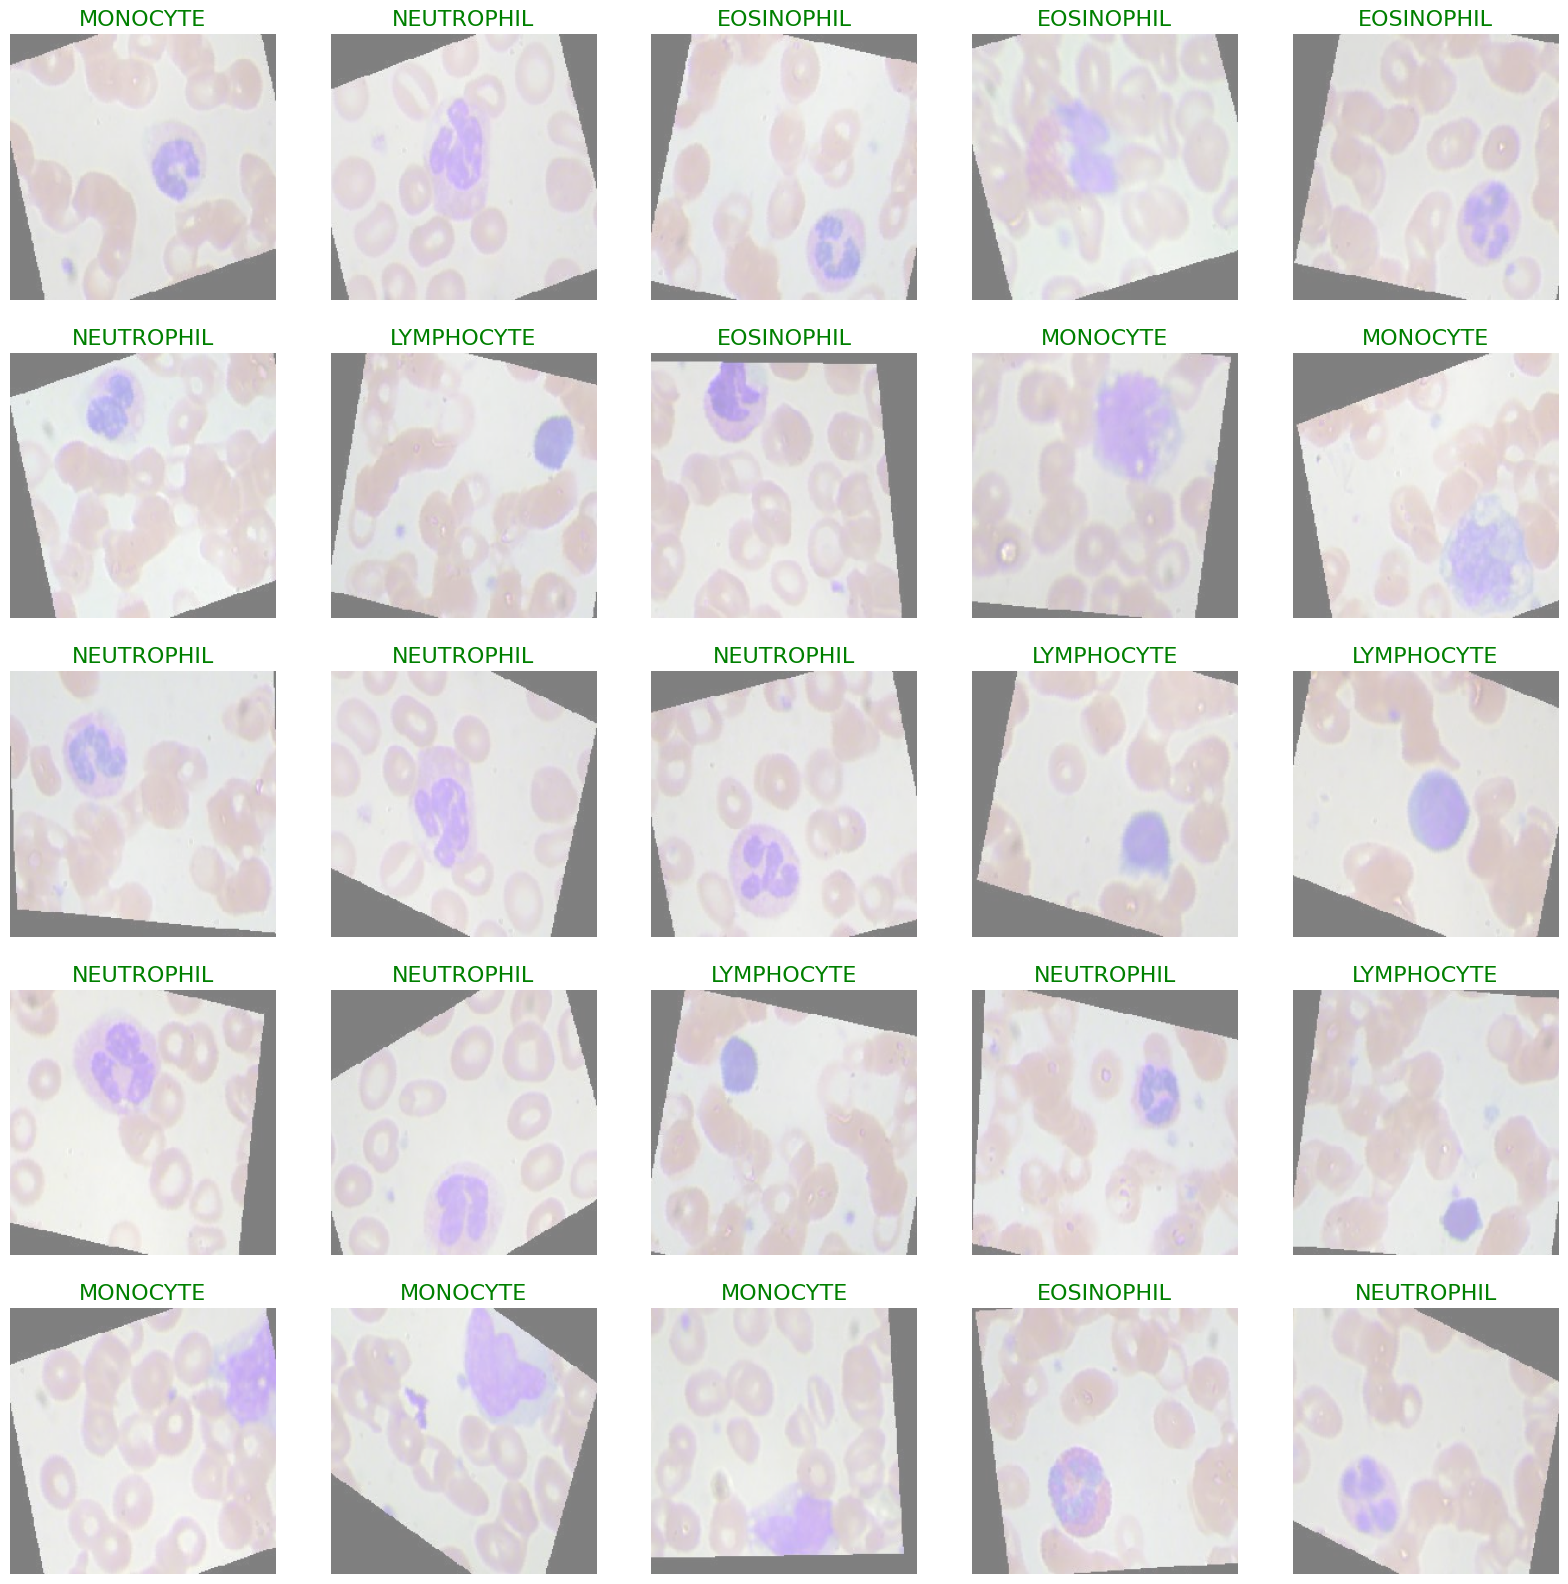

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Define directories for training and testing data
train_dir = "/content/dataset2-master/dataset2-master/images/TRAIN"
test_dir = "/content/dataset2-master/dataset2-master/images/TEST"

# Create an ImageDataGenerator for data loading and preprocessing
datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

# Load testing data
test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

# Function to display a grid of images from the generator
def show_knee_images(image_gen):
    test_dict = image_gen.class_indices
    classes = list(test_dict.keys())

    images, labels = next(image_gen)

    plt.figure(figsize=(20, 20))
    length = len(labels)

    if length < 25:
        r = length
    else:
        r = 25

    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = (images[i] + 1) / 2 # Adjust if images are already in [0,1]
        plt.imshow(image)

        index = np.argmax(labels[i])
        class_name = classes[index]

        plt.title(class_name, color="green", fontsize=16)
        plt.axis('off')

    plt.show()

# Call the function to display images from the training data
show_knee_images(train_data)

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train and test
train_images, test_images = train_test_split(
    bloodCell_df,
    test_size=0.3,
    random_state=42
)

# Split training again into train and validation
train_set, val_set = train_test_split(
    bloodCell_df,
    test_size=0.2,
    random_state=42
)

# Print shapes
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)


(7965, 2)
(2988, 2)
(1992, 2)
(6969, 2)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Image generator with MobileNetV2 preprocessing
image_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Train generator
train = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(244, 244),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)

# Test generator
test = image_gen.flow_from_dataframe(
    dataframe=test_images,
    x_col="filepaths",
    y_col="labels",
    target_size=(244, 244),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)

# Validation generator
val = image_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(244, 244),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)


Found 7965 validated image filenames belonging to 4 classes.
Found 2988 validated image filenames belonging to 4 classes.
Found 1992 validated image filenames belonging to 4 classes.


In [ ]:
from tensorflow import keras
import tensorflow as tf

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3),
                        activation="relu", input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1),
                        activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1),
                        activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1),
                        activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1),
                        activation="relu", padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3),
                        activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3),
                        activation="relu", padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3),
                        activation="relu", padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3),
                        activation="relu", padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation="softmax")
])

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"]
)

model.summary()

history = model.fit(
    train,
    epochs=10,
    validation_data=val
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 512)      │         2,04

 Total params: 15,611,524 (59.55 MB)

 Trainable params: 15,605,124 (59.53 MB)

 Non-trainable params: 6,400 (25.00 KB)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


996/996 ━━━━━━━━━━━━━━━━━━━━ 125s 106ms/step - accuracy: 0.3296 - loss: 1.9833 - val_accuracy: 0.5738 - val_loss: 1.0002
Epoch 2/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 94s 94ms/step - accuracy: 0.5202 - loss: 1.0877 - val_accuracy: 0.6867 - val_loss: 0.7577
Epoch 3/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 94s 94ms/step - accuracy: 0.6797 - loss: 0.7697 - val_accuracy: 0.7249 - val_loss: 0.6078
Epoch 4/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 94s 94ms/step - accuracy: 0.7916 - loss: 0.5044 - val_accuracy: 0.8870 - val_loss: 0.2976
Epoch 5/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 94s 94ms/step - accuracy: 0.8638 - loss: 0.3409 - val_accuracy: 0.9121 - val_loss: 0.2118
Epoch 6/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 94s 94ms/step - accuracy: 0.9043 - loss: 0.2444 - val_accuracy: 0.9086 - val_loss: 0.2341
Epoch 7/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 94s 94ms/step - accuracy: 0.9339 - loss: 0.1855 - val_accuracy: 0.8298 - val_loss: 0.4829
Epoch 8/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 93s 94ms/step - accuracy: 0.9487 - loss: 0.1408 - val_accur

374/374 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step


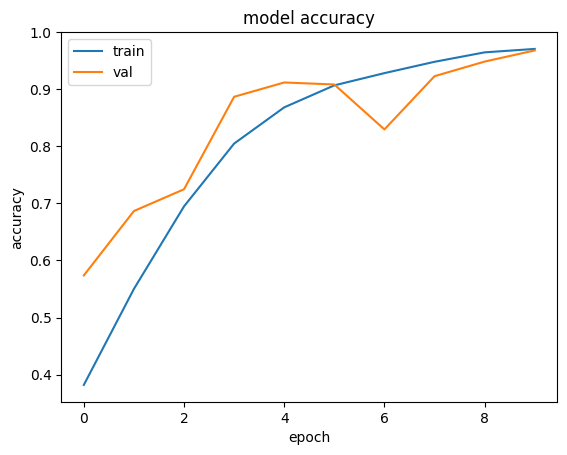

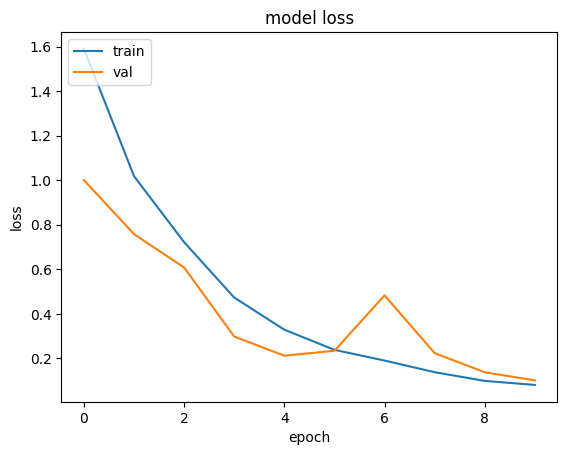

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Predictions
pred = model.predict(test)
pred = np.argmax(pred, axis=1)  # pick class with highest probability

# Convert numeric labels to class names
labels = train.class_indices
labels = dict((v, k) for k, v in labels.items())
pred2 = [labels[k] for k in pred]

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# True labels from test set
y_test = test_images.labels  # expected output labels

# Classification report
print(classification_report(y_test, pred2))

# Overall accuracy
print("Accuracy of the Model: {:.1f}%".format(accuracy_score(y_test, pred2) * 100))


              precision    recall  f1-score   support

  EOSINOPHIL       0.97      0.94      0.95       744
  LYMPHOCYTE       1.00      1.00      1.00       716
    MONOCYTE       1.00      1.00      1.00       781
  NEUTROPHIL       0.94      0.97      0.96       747

    accuracy                           0.98      2988
   macro avg       0.98      0.98      0.98      2988
weighted avg       0.98      0.98      0.98      2988

Accuracy of the Model: 97.7%


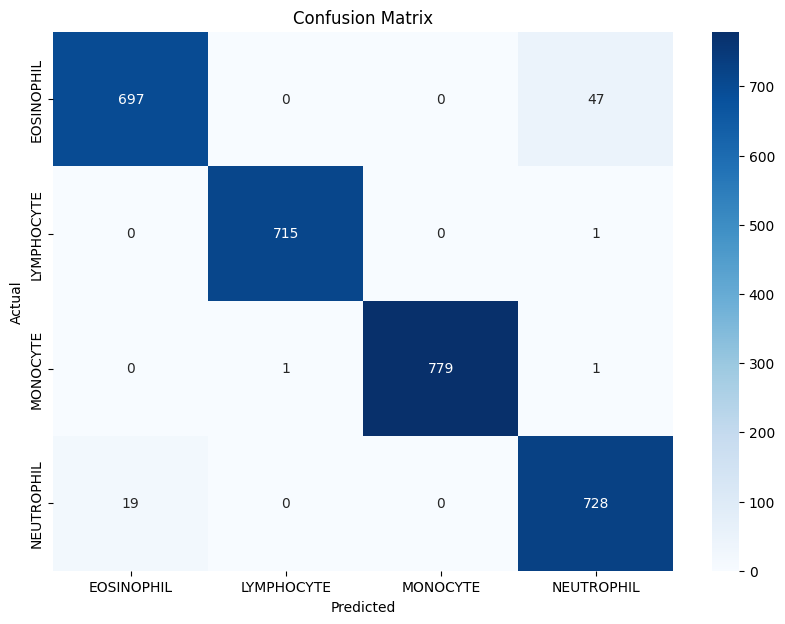

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Class labels
class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

# Compute confusion matrix
cm = confusion_matrix(y_test, pred2)

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Axis labels and ticks
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Title
plt.title("Confusion Matrix")

plt.show()


In [ ]:
model.save("Blood Cell.h5")

from google.colab import files
files.download("Blood Cell.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install transformers torch gradio accelerate bitsandbytes diffusers torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 14.1 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from diffusers import StableDiffusionPipeline
from torchvision import models, transforms
from PIL import Image
import gradio as gr
import torch

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [ ]:
# Load IBM Granite Model
model_name = "ibm-granite/granite-3.3-2b-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

granite_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/787 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/362 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

Passing `generation_config` together with generation-related arguments=({'max_new_tokens'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.


In [ ]:
# Load Transfer Learning CNN MODEL
model_cnn = models.resnet50(pretrained=True)
model_cnn.fc = torch.nn.Linear(model_cnn.fc.in_features, 3)  # 3 classes: RBC, WBC, Platelet
model_cnn.eval()
# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
# Blood Cell Classes
classes = [
    "microscopic image of human blood smear with eosinophil, lymphocyte, monocyte, and neutrophil blood cells, high detail"
]

# Classification Function
def classify_image(img):

    image = transform(img).unsqueeze(0)

    with torch.no_grad():
        outputs = model_cnn(image)
        _, predicted = torch.max(outputs, 1)

    return classes[predicted.item()]

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


In [ ]:
def generate_report(cell_type):

    prompt = f"Explain the characteristics and clinical significance of a {cell_type}."

    response = granite_pipeline(prompt)[0]['generated_text']

    return response


In [ ]:

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from diffusers import StableDiffusionPipeline
import gc
import logging

# Configure logging for better visibility
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Step 1: Clear existing models from GPU (if any) and Python memory ---
logging.info("Starting aggressive memory cleanup...")

# Delete IBM Granite components if they exist globally
if 'granite_model' in globals() and granite_model is not None and hasattr(granite_model, 'to'):
    logging.info(f"Moving existing granite_model to CPU from {granite_model.device} before deletion...")
    try:
        granite_model.to('cpu')
        del granite_model
        logging.info("granite_model deleted.")
    except Exception as e:
        logging.error(f"Error moving/deleting granite_model: {e}")

if 'granite_tokenizer' in globals() and granite_tokenizer is not None:
    try:
        del granite_tokenizer
        logging.info("granite_tokenizer deleted.")
    except Exception as e:
        logging.error(f"Error deleting granite_tokenizer: {e}")

if 'granite_pipeline' in globals() and granite_pipeline is not None:
    try:
        del granite_pipeline
        logging.info("granite_pipeline deleted.")
    except Exception as e:
        logging.error(f"Error deleting granite_pipeline: {e}")

# Delete the separate PyTorch model_cnn if it exists globally (from ynTb7dQAI0c6)
# Note: model_cnn is a Keras model, it doesn't have a '.device' attribute or '.to()' method like PyTorch models.
# Simply deleting the variable will release its resources.
if 'model_cnn' in globals() and model_cnn is not None:
    logging.info("Deleting model_cnn (Keras ResNet50)...")
    try:
        del model_cnn
        logging.info("model_cnn (Keras ResNet50) deleted.")
    except Exception as e:
        logging.error(f"Error deleting model_cnn: {e}")

# Delete the previously loaded Stable Diffusion pipe if it exists globally
if 'pipe' in globals() and pipe is not None and hasattr(pipe, 'to'):
    logging.info(f"Moving existing Stable Diffusion pipe to CPU from {pipe.device} before deletion...")
    try:
        pipe.to('cpu')
        del pipe
        logging.info("Stable Diffusion pipe deleted.")
    except Exception as e:
        logging.error(f"Error moving/deleting Stable Diffusion pipe: {e}")

# Force garbage collection and clear CUDA cache
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
logging.info("Aggressive memory cleanup completed: Garbage collected and CUDA cache emptied.")


# --- Step 2: Load Keras Classification Model on CPU ---
logging.info("Loading Keras classification model on CPU...")
classification_model = None
try:
    classification_model = keras.models.load_model("Blood Cell.h5")
    logging.info("Keras classification model loaded successfully.")
except Exception as e:
    logging.error(f"Error loading Keras classification model: {e}")

# Define class labels corresponding to the model's output
class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

# Image preprocessing for the Keras model
def preprocess_image_for_classification(image: Image.Image):
    if classification_model is None:
        return None # Indicate that model is not available
    image = image.resize((224, 224))  # Resize to model's expected input
    image = np.array(image).astype('float32') / 255.0 # Convert to numpy array and normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

logging.info("Keras classification model loading and preprocessing function defined.")


# --- Step 3: Load Text Generation Model on CPU ---
logging.info("Loading IBM Granite text generation model on CPU...")
granite_model_loaded = False
granite_pipeline = None
try:
    granite_tokenizer = AutoTokenizer.from_pretrained(model_name_granite)
    granite_model = AutoModelForCausalLM.from_pretrained(
        model_name_granite,
        torch_dtype=torch.float32,
        device_map="cpu"
    )
    granite_pipeline = pipeline(
        "text-generation",
        model=granite_model,
        tokenizer=granite_tokenizer,
        max_new_tokens=512
    )
    granite_model_loaded = True
    logging.info("IBM Granite text generation model loaded on CPU successfully.")
except Exception as e:
    logging.error(f"Error loading IBM Granite text generation model on CPU: {e}")

# Function to generate report
def generate_report(cell_type):
    if not granite_model_loaded or granite_pipeline is None:
        return "AI Report generation is currently unavailable due to model loading issues." # Fallback if model failed to load
    prompt = f"Explain the characteristics and clinical significance of a {cell_type}."
    try:
        output = granite_pipeline(prompt)
        if output and isinstance(output, list) and len(output) > 0 and 'generated_text' in output[0]:
            return output[0]['generated_text']
        else:
            logging.warning(f"granite_pipeline output unexpected: {output}")
            return "Could not generate report due to unexpected pipeline output."
    except Exception as e:
        logging.error(f"Error during AI report generation: {e}")
        return "Error occurred during AI report generation."


# --- Step 4: Stable Diffusion Setup ---
logging.info("Loading Stable Diffusion pipeline...")
stable_diffusion_loaded = False
pipe = None
try:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sd_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

    pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=sd_dtype,
        low_cpu_mem_usage=True
    )
    pipe.enable_attention_slicing()
    pipe.enable_model_cpu_offload()
    stable_diffusion_loaded = True
    logging.info("Stable Diffusion pipeline loaded and configured successfully.")
except Exception as e:
    logging.error(f"Error loading Stable Diffusion pipeline: {e}")

# Function to generate blood smear image
def generate_blood_smear_image():
    if not stable_diffusion_loaded or pipe is None:
        logging.warning("Stable Diffusion model not loaded. Cannot generate image.")
        return Image.new('RGB', (224, 224), color = 'red') # Placeholder red image
    prompt = "microscopic image of human blood smear with eosinophil, lymphocyte, monocyte, and neutrophil blood cells, high detail"
    try:
        generated_image = pipe(prompt).images[0]
        return generated_image
    except Exception as e:
        logging.error(f"Error generating blood smear image: {e}")
        return Image.new('RGB', (224, 224), color = 'red') # Placeholder for generation error


# --- Step 5: Define Combined Gradio Prediction Function ---
def process_blood_image(input_image: Image.Image):
    # 1. Classify the uploaded image
    classification_result = "Classification unavailable: Model not loaded or errored."
    if classification_model is not None:
        processed_image = preprocess_image_for_classification(input_image)
        if processed_image is not None:
            try:
                predictions = classification_model.predict(processed_image)
                predicted_class_idx = np.argmax(predictions, axis=1)[0]
                confidence = np.max(predictions)
                predicted_class_name = class_labels[predicted_class_idx]
                classification_result = f"Class: {predicted_class_name}, Confidence: {confidence:.2f}"
            except Exception as e:
                logging.error(f"Error during classification prediction: {e}")
                classification_result = f"Classification error: {e}"
        else:
            classification_result = "Classification unavailable: Image preprocessing failed."


    # 2. Generate an AI report based on the classification
    # Use a generic prompt if classification failed or model not loaded
    ai_report_cell_type = locals().get('predicted_class_name', 'blood cell')
    ai_report = generate_report(ai_report_cell_type)


    # 3. Generate a synthetic blood smear image
    synthetic_image = generate_blood_smear_image()

    return classification_result, ai_report, synthetic_image


# --- Step 6: Create Gradio Interface ---
logging.info("Building Gradio Interface...")
with gr.Blocks() as demo_combined:
    gr.Markdown("# 🩸 Blood Cell Analysis and Synthesis 🧬")
    gr.Markdown("Upload a blood cell image for classification, get an AI-generated report, and see a synthetic blood smear image.")

    with gr.Row():
        with gr.Column():
            input_image_comp = gr.Image(type="pil", label="Upload Blood Cell Image")
            process_button = gr.Button("Analyze & Generate")
        with gr.Column():
            classification_output = gr.Label(label="Classification Result")
            report_output = gr.Textbox(label="AI-Generated Report", lines=10)
            synthetic_image_output = gr.Image(type="pil", label="Synthetic Blood Smear Image")

    process_button.click(
        fn=process_blood_image,
        inputs=[input_image_comp],
        outputs=[classification_output, report_output, synthetic_image_output]
    )

    # Use queue() to allow multiple requests and better handle long inference times
    # This is especially important for models like Stable Diffusion and large LLMs.
    demo_combined.queue()

demo_combined.launch(share=True)
logging.info("Gradio Interface launched.")

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
ERROR:root:Error loading IBM Granite text generation model on CPU: name 'model_name_granite' is not defined
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

StableDiffusionSafetyChecker LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/safety_checker
Key                                               | Status     |  | 
--------------------------------------------------+------------+--+-
vision_model.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b898e7d9939c22adcd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
